# Clustering and Similarity

Finding structures in unlabeled data (unsupervised learning).

![Clustering Workflow](figures/clustering_workflow.png)

In [1]:
%matplotlib inline 

import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 

sns.set_context('notebook')
sns.set_style('whitegrid')

In [2]:
# Load Datasets for Examples 
from sklearn.datasets import make_blobs, make_moons, make_circles

blobs, yb = make_blobs(n_samples=200, centers=5, n_features=12, cluster_std=[1.0, 5.0, 3.0, 2.0, 2.0], random_state=42)
moons, ym = make_moons(n_samples=200, random_state=42)
circles, yc = make_circles(n_samples=200, random_state=42)

## Distance and Similarity

When data is represented spatially, then the _distance_ between points in feature space becomes very important. 

In this space, distance becomes equivalent to similarity; e.g. the closer to points are, the more similar they are. We consider two points in the same position to be identical. 

So how do you measure the distance between two points?

![Distance](figures/minkowski.png)

TODO: add the code to generate this graph to the utils.

### Minkowski Distance 

Given the above plot, we know that Manhattan distance (taxicab distance) is given by: 

$$d_{manhattan}(x,y)=\sum_{i=0}^n|x_i-y_i|$$

And that Euclidean distance is given by:

$$d_{euclidean}(x,y) = (\sum_{i=0}^n|x_i-y_i|^2)^{\frac{1}{2}}$$

Hopefully these look familiar to the vector norms (which are just a distance from the origin)! Minkowski distance generalizes these formulas with a parameter, $p$:

$$d(x,y)=(\sum_{i=0}^n|x_i-y_i|^p)^{\frac{1}{p}}$$

### Mahalanobis Distance 

Minkowski distance assumes that all data is _symmetric_, e.g. that distance is the same in all dimensions. We refer to this as a _spherical_ distance metric. 

Mahalanobis distance considers the volatility of the data in each dimension, creating a variable, $s_i$ (the standard deviation of that set of data) to normalize the data in that direction. 

Similar to Minkowski distance, it can be generalized, here is the standard representation for $p=2$:

$$d(x,y)=\sqrt{\sum_{i=0}^n \frac {(x_i-y_i)^2} {s_i^2}}$$

![Distance](figures/mahalanobis.png)

TODO: add the code to generate this graph to the utils

### Cosine Distance 

Generally spherical distance is a desired property, but in really sparse space (like text analysis), point-to-point distances may create arbitrary similarities along shared dimensions. 

Cosine distance is a spherical distance metric that measures the angle between the vectors of two points in feature space. 

While it's technically not a true distance metric (it's only usable in positive space) it is faster to compute and is closer to pearson correlation. 

![Cosine Distance](figures/cosine_distance.png)

TODO: matplotlib the cosine distance graph!

### Other Distance Metrics

![Distance Table](figures/distance_table.png)

TODO: add distance metrics table here, particularly novel metrics from [sklearn.neighbors.DistanceMetric](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html). 

## Partitive Clustering

Partitive clustering is a top-down approach to clustering that divides (partitions) the data into groups that are identified by _centers_ (or sometimes called _centroids_). 

- K-Means family (K-Medoids, K-Modes, etc) 
- Spectral clustering 
- Affinity Propagation
- DBSCAN/OPTICS
- Self-Organizing Maps

### K-Means

Fairly straight forward algorithm:

- Select predefined $K$ 
- Pick $K$ _random_ points in the data set to be centroids 
- For each point, assign it to the closest centroid 
- Compute the middle of the cluster, move centroid to that point 
- Repeat previous 2 steps until centers don't move. 

Considerations:

- Distance metric 
- How do you choose $K$?

TODO: add k-means animation showing cluster selection in 2 dimensions.

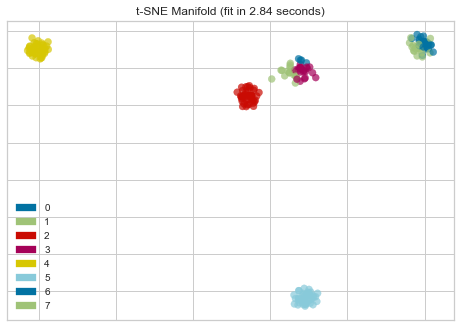

In [3]:
from sklearn.cluster import KMeans 
from yellowbrick.features.manifold import Manifold

model = KMeans(n_clusters=8)
model.fit(blobs)

viz = Manifold(manifold='tsne', target='discrete')
viz.fit(blobs, model.predict(blobs))
viz.poof()

| Pros | Cons |
| ---- | ---- | 
| Will find most optimal cluster centers | What $K$ to use? | 
| Clusters are spherical | Hard boundaries (no grey-areas) |
| Guaranteed to converge | Spherical clusters | 
| Fast to compute | Stochastic behavior | 

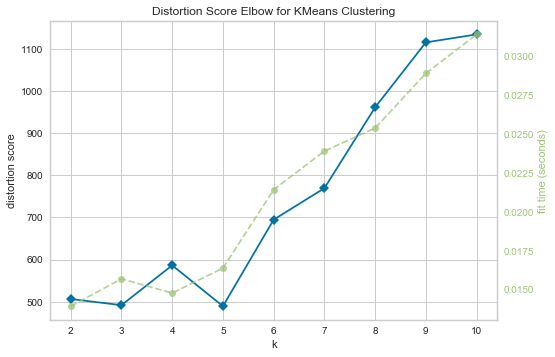

In [4]:
from yellowbrick.cluster import KElbowVisualizer

viz = KElbowVisualizer(KMeans())
viz.fit(blobs)
viz.poof()

## Clustering Metrics

Clustering evaluation is largely qualitative since the problem is unsupervised, there are no "right" answers". 

Our intuition for cluster model selection is that our hypothesis (there exists an underlying, observable structure to the data) can be confirmed such that different structures will exhibit different behaviors for different model selection triples. 

We can see this intuition in 2 dimensions &hellip; though of course in high dimensional space, we have to jump through other hoops to get a sense for what's happening in the underlying data. 

![Clustering Algorithms](figures/clustering_algorithms.png)

TODO: add the [code](http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html) that generates the above image to utils.

### Silhouette Scores

A model's silhouette coefficient communicates the density of clusters determined by the model. The metric is computed by averaging the difference between the average distance of all points in a cluster and the average nearest-cluster distance. 

Silhouette scores are used in centroidal models to show that clusters are well connected (all points are close to each other) and that they don't overlap with other clusters. 

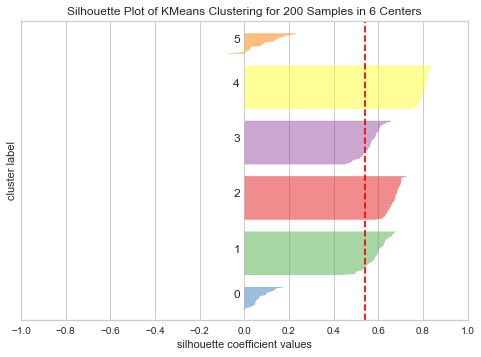

In [11]:
from yellowbrick.cluster import SilhouetteVisualizer

viz = SilhouetteVisualizer(KMeans(n_clusters=6))
viz.fit(blobs)
viz.poof()

### Inter-Cluster Distance Maps

Inter-cluster distance maps display an embedding of the cluster centers in 2 dimensions with the distance to other centers preserved. E.g. the closer to centers are in the visualization, the closer they are in the original feature space. 

The clusters are sized according to a scoring metric. By default, they are sized by membership, e.g. the number of instances that belong to each center. This gives a sense of the relative importance of clusters. 

Note however, that because two clusters overlap in the 2D space, it does not imply that they overlap in the original feature space.

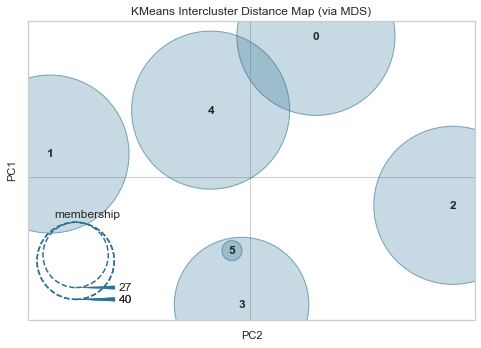

In [9]:
from yellowbrick.cluster.icdm import InterclusterDistance

viz = InterclusterDistance(KMeans(n_clusters=6))
viz.fit(blobs)
viz.poof()

### Rand Index

Computes the similarity measure between two clusters by considering all pairs of samples and determining if they should have been assigned together or should have been assigned to different clusters. 

Unfortunately to compute this score, the true values of the underlying structure are required, which is not often available.

In [13]:
from sklearn.metrics import adjusted_rand_score 

model = KMeans(n_clusters=3)
model.fit(blobs)
adjusted_rand_score(yb, model.predict(blobs))

0.4776902887139107

## Hierarchical Clustering

Hierarchical clustering groups related data into the same clusters in an iterative fashion to create a hierarchy of similarity rather than discrete groups or centers. This can be done with a bottom-up approach (**agglomerative**) or a top-down approach (**divisive**). 

- Agglomerative Clustering 
- Mean-shift 
- Ward Hierarchical Clustering 
- Birch

### Agglomerative Clustering 

We want strong membership as a hierarchy, follow the following procedure:

- Start with all data points in their own cluster 
- Repeat until only a single cluster is left:
    - Find 2 closest points, $x_i$ and $x_j$
    - Merge points into a single cluster, defined by their center 
    - Remove previous singleton clusters 
   
This method creates a dendrogram of clusters, a hierarchical tree representing the cluster structure. 

![Dendrogram](figures/dendrogram.png)

TODO: add animation of hierarchical clustering working

## Curse of Dimensionality

High dimensional data tends to be sparse and points are relatively more distant from each other. Algorithms that are based in locality need to determine nearness, but more or less dimensions can skew results. 

This occurs because as the number of dimensions is increased, the average distance between points gets larger; conversely as the number of dimensions is decreased, the average distance gets larger. 

Going from 3 dimensions to 2; distance that was embedded in $R^3$ may arbitrarily place points closer to each other in $R^2$ that were previously more distant. 

![Curse of Dimensionality](figures/curse_of_dimensionality.png)

TODO: write matplotlib script that draws the above graphs.

### No Free Lunch

Cannot have more than two of the following properties:

- **Richness**: there exists a distance function that can yield all different types of partitions. 
- **Scale Invariance**: if numbers are scaled, the same clusters should be observed, units don't matter. 
- **Consistency**: shrinking the distance between points, then expanding them should yield the same result. 

Most clustering has richness and scale-invariance but not consistency. 